In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df_fire= pd.read_csv(open('fire_archive_M6_96619.csv',encoding='gb18030'))

In [3]:
df_fire

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,-11.8070,142.0583,313.0,1.0,1.0,2019-08-01,56,Terra,MODIS,48,6.3,297.3,6.6,D,0
1,-11.7924,142.0850,319.3,1.0,1.0,2019-08-01,56,Terra,MODIS,71,6.3,297.3,11.3,D,0
2,-12.8398,132.8744,311.6,3.1,1.7,2019-08-01,57,Terra,MODIS,42,6.3,298.7,23.1,D,0
3,-14.4306,143.3035,310.1,1.1,1.1,2019-08-01,57,Terra,MODIS,33,6.3,296.1,6.5,D,0
4,-12.4953,131.4897,310.3,4.0,1.9,2019-08-01,57,Terra,MODIS,36,6.3,298.8,27.6,D,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36006,-28.0656,131.6334,312.7,1.2,1.1,2019-09-30,1644,Aqua,MODIS,85,6.3,292.9,14.2,N,0
36007,-28.2625,128.5494,304.9,1.0,1.0,2019-09-30,1644,Aqua,MODIS,27,6.3,290.9,6.4,N,0
36008,-28.2941,128.5123,301.7,1.0,1.0,2019-09-30,1644,Aqua,MODIS,43,6.3,290.4,5.5,N,0
36009,-28.3001,128.5530,303.6,1.0,1.0,2019-09-30,1644,Aqua,MODIS,41,6.3,290.3,5.7,N,0


In [4]:
df_fire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36011 entries, 0 to 36010
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    36011 non-null  float64
 1   longitude   36011 non-null  float64
 2   brightness  36011 non-null  float64
 3   scan        36011 non-null  float64
 4   track       36011 non-null  float64
 5   acq_date    36011 non-null  object 
 6   acq_time    36011 non-null  int64  
 7   satellite   36011 non-null  object 
 8   instrument  36011 non-null  object 
 9   confidence  36011 non-null  int64  
 10  version     36011 non-null  float64
 11  bright_t31  36011 non-null  float64
 12  frp         36011 non-null  float64
 13  daynight    36011 non-null  object 
 14  type        36011 non-null  int64  
dtypes: float64(8), int64(3), object(4)
memory usage: 4.1+ MB


In [5]:
#数据预测
df_fire=df_fire.drop(['acq_date','acq_time','satellite','instrument','version','type'],axis=1)

In [6]:
daynight = pd.get_dummies(df_fire['daynight'],drop_first=True)
df_fire.drop(['daynight'],axis=1,inplace=True)
df_fire = pd.concat([df_fire,daynight],axis=1)

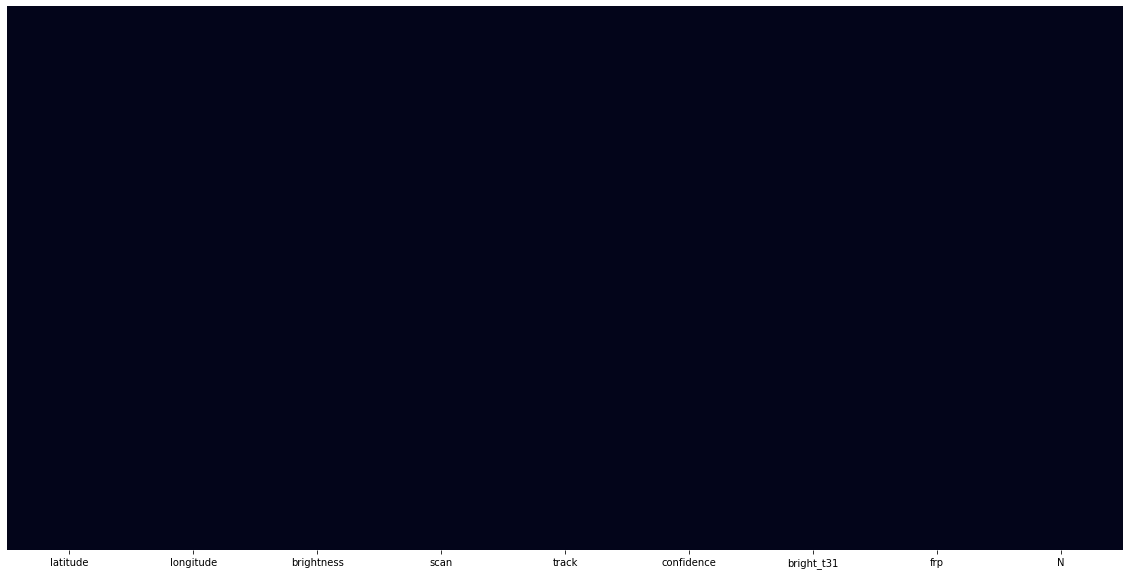

In [7]:
plt.figure(figsize=(20,10))
sns.heatmap(df_fire.isnull() , yticklabels=False ,cbar=False)

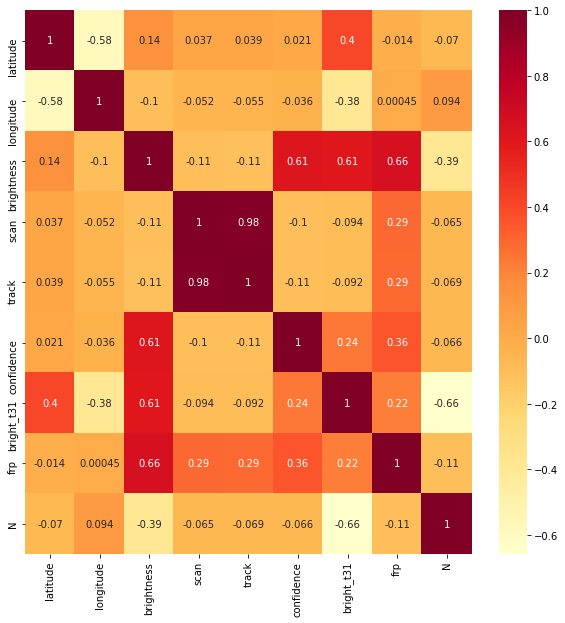

In [8]:
figure= plt.figure(figsize=(10,10))
sns.heatmap(df_fire.corr(), annot=True, cmap="YlOrRd")

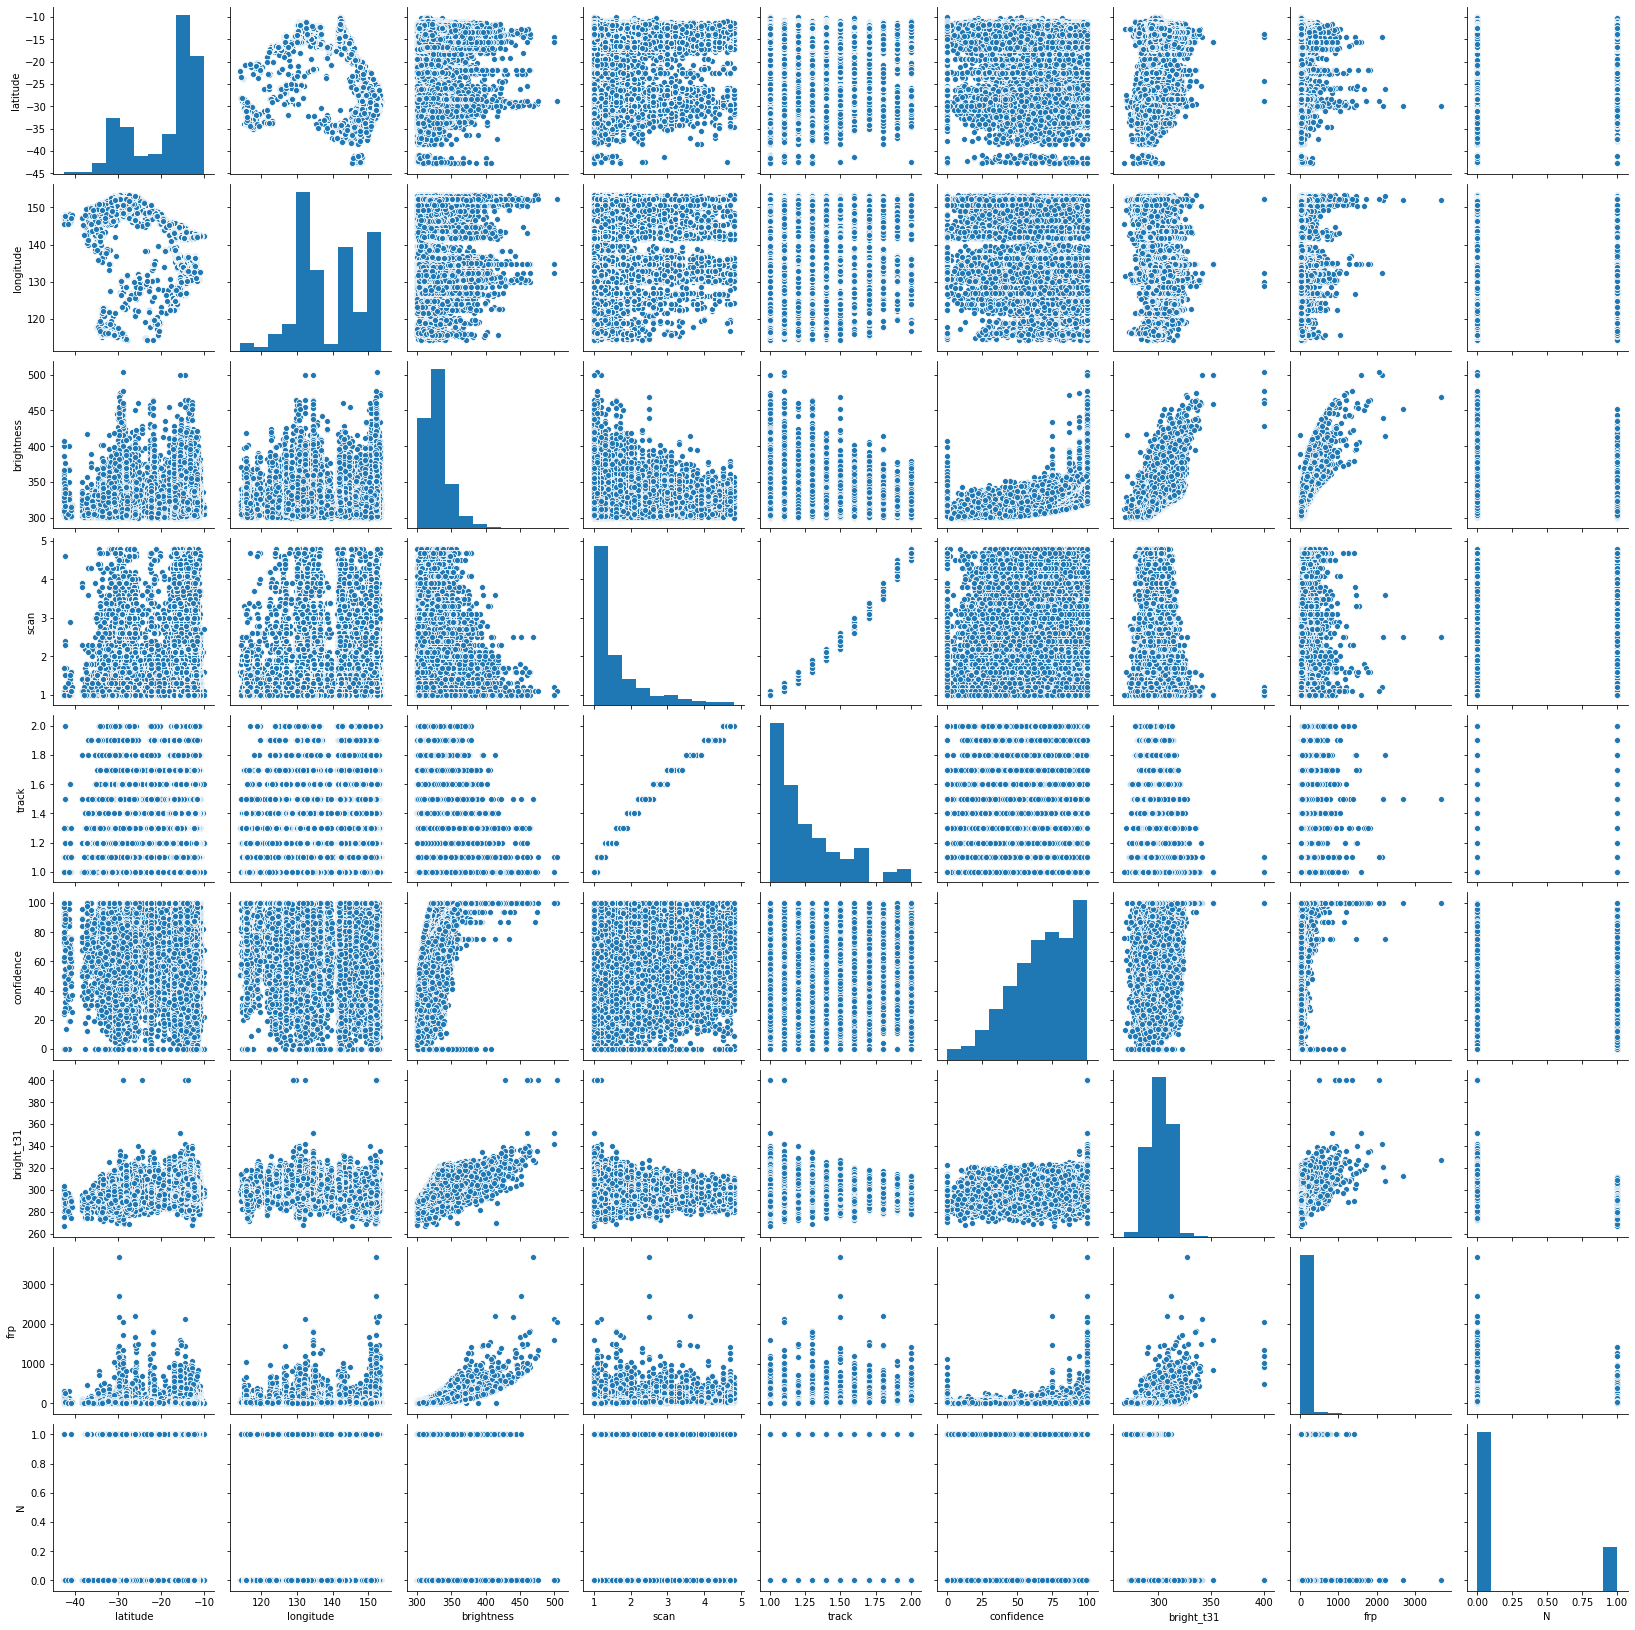

In [9]:
sns.pairplot(df_fire)

In [10]:
X= df_fire.drop('brightness',axis=1)
y=df_fire['brightness']

In [12]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X ,y , test_size=0.3, random_state=108)

In [13]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

results_df = pd.DataFrame()
columns = ["Model", "Cross Val Score", "MAE", "MSE", "RMSE", "R2"]

def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

def append_results(model_name, model, results_df, y_test, pred):
    results_append_df = pd.DataFrame(data=[[model_name, *evaluate(y_test, pred) , cross_val_score(model, X, y, cv=10).mean()]], columns=columns)
    results_df = results_df.append(results_append_df, ignore_index = True)
    return results_df

In [45]:
from sklearn.linear_model import RANSACRegressor
ransacReg= RANSACRegressor()
ransacReg.fit(X_train,y_train)
pred= ransacReg.predict(X_test)

In [46]:
results_df= append_results("Robust Regression",RANSACRegressor(),results_df,y_test,pred)
results_df

,Model,Cross Val Score,MAE,MSE,RMSE,R2
0,Robust Regression,7.038882,521.690027,22.840535,-0.415843,-0.725802


In [47]:
from sklearn.linear_model import Ridge
RidgeReg= Ridge()
RidgeReg.fit(X_train,y_train)
pred= RidgeReg.predict(X_test)

In [48]:
results_df= append_results("Ridge Regression",Ridge(),results_df,y_test,pred)
results_df

,Model,Cross Val Score,MAE,MSE,RMSE,R2
0,Robust Regression,7.038882,521.690027,22.840535,-0.415843,-0.725802
1,Ridge Regression,5.766171,69.844011,8.357273,0.810447,0.791846


In [49]:
from sklearn.linear_model import Lasso
LassoReg= Lasso()
LassoReg.fit(X_train,y_train)
pred= LassoReg.predict(X_test)

In [50]:
results_df= append_results("Lasso Regression",Lasso(),results_df,y_test,pred)
results_df

,Model,Cross Val Score,MAE,MSE,RMSE,R2
0,Robust Regression,7.038882,521.690027,22.840535,-0.415843,-0.725802
1,Ridge Regression,5.766171,69.844011,8.357273,0.810447,0.791846
2,Lasso Regression,6.061048,73.954868,8.599702,0.799290,0.783797


In [51]:
from sklearn.linear_model import ElasticNet
ElasticNetReg= ElasticNet()
ElasticNetReg.fit(X_train,y_train)
pred= ElasticNetReg.predict(X_test)

In [52]:
results_df= append_results("ElasticNet Regression",ElasticNet(),results_df,y_test,pred)
results_df

,Model,Cross Val Score,MAE,MSE,RMSE,R2
0,Robust Regression,7.038882,521.690027,22.840535,-0.415843,-0.725802
1,Ridge Regression,5.766171,69.844011,8.357273,0.810447,0.791846
2,Lasso Regression,6.061048,73.954868,8.599702,0.799290,0.783797
3,ElasticNet Regression,6.158283,75.541702,8.691473,0.794983,0.779806


In [14]:
from sklearn import ensemble
model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(n_estimators=100)#这里使用100个决策树
model_GradientBoostingRegressor.fit(X_train,y_train)
pred=model_GradientBoostingRegressor.predict(X_test)

In [15]:
results_df= append_results("GBRT Regression",ElasticNet(),results_df,y_test,pred)
results_df

NameError: name 'ElasticNet' is not defined

In [55]:
####3.1决策树回归####
from sklearn import tree
model_DecisionTreeRegressor = tree.DecisionTreeRegressor()
model_DecisionTreeRegressor.fit(X_train,y_train)
pred=model_DecisionTreeRegressor.predict(X_test)

In [56]:
results_df= append_results("DecisionTree Regression",ElasticNet(),results_df,y_test,pred)
results_df

,Model,Cross Val Score,MAE,MSE,RMSE,R2
0,Robust Regression,7.038882,521.690027,22.840535,-0.415843,-0.725802
1,Ridge Regression,5.766171,69.844011,8.357273,0.810447,0.791846
2,Lasso Regression,6.061048,73.954868,8.599702,0.799290,0.783797
3,ElasticNet Regression,6.158283,75.541702,8.691473,0.794983,0.779806
4,GBRT Regression,1.967371,6.880404,2.623052,0.981327,0.779806
5,DecisionTree Regression,2.021399,10.292051,3.208123,0.972068,0.779806


In [57]:
####3.3SVM回归####
from sklearn import svm
model_SVR = svm.SVR()
model_SVR.fit(X_train,y_train)
pred=model_SVR.predict(X_test)

In [58]:
results_df= append_results("SVM Regression",ElasticNet(),results_df,y_test,pred)
results_df

,Model,Cross Val Score,MAE,MSE,RMSE,R2
0,Robust Regression,7.038882,521.690027,22.840535,-0.415843,-0.725802
1,Ridge Regression,5.766171,69.844011,8.357273,0.810447,0.791846
2,Lasso Regression,6.061048,73.954868,8.599702,0.799290,0.783797
3,ElasticNet Regression,6.158283,75.541702,8.691473,0.794983,0.779806
4,GBRT Regression,1.967371,6.880404,2.623052,0.981327,0.779806
5,DecisionTree Regression,2.021399,10.292051,3.208123,0.972068,0.779806
6,SVM Regression,5.773091,72.589192,8.519929,0.802996,0.779806


In [59]:
0.2718*np.array([0.1094, 0.1195, 0.1969, 0.2461, 0.3281])

array([0.02973492, 0.0324801 , 0.05351742, 0.06688998, 0.08917758])

In [60]:
0.3293*np.array([0.0909,0.4545, 0.4545])

array([0.02993337, 0.14966685, 0.14966685])

In [61]:
0.3989*np.array([0.1111,0.3333, 0.5556])

array([0.04431779, 0.13295337, 0.22162884])